<a href="https://colab.research.google.com/github/Al-Abdallat/Al-Abdallat/blob/main/Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

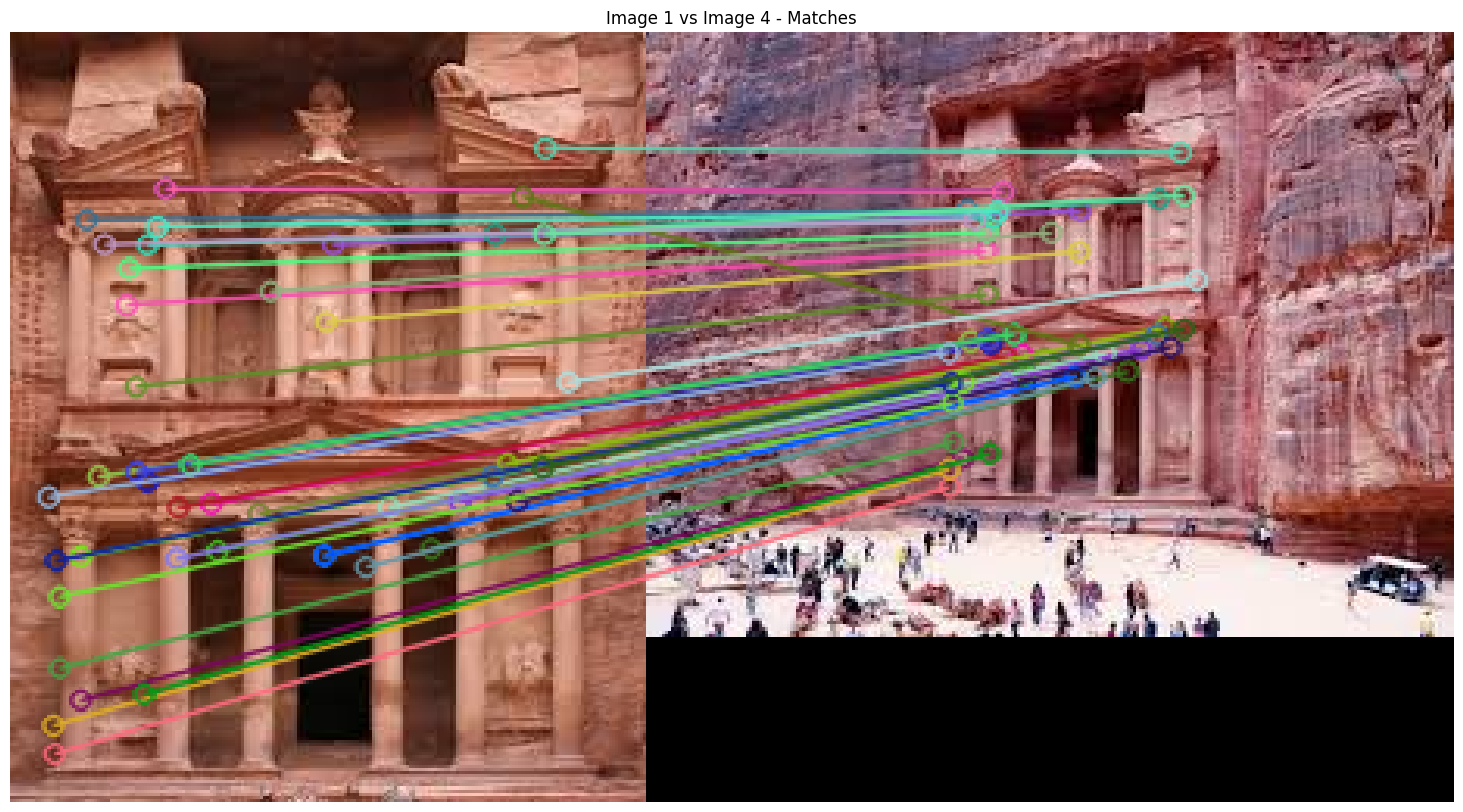

In [19]:
import cv2
import matplotlib.pyplot as plt
import os

# Function to detect SIFT features in an image
def detect_sift_features(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect SIFT features (keypoints) and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    return image, keypoints, descriptors

# Function to match SIFT features between two sets of keypoints and descriptors
def match_features(desc1, desc2):
    # Initialize Brute-Force matcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(desc1, desc2)

    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

# List of image file paths
image_paths = ['/content/petra1.jpg', '/content/petra2.jpg', '/content/petra3.JPG', '/content/petra4.jpg']

# Detect SIFT features for each image
sift_results = []
for image_path in image_paths:
    try:
        result = detect_sift_features(image_path)
        sift_results.append(result)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue

# Ensure we have the first image and at least one more to match with
if len(sift_results) < 2:
    raise ValueError("Not enough images to perform matching.")

# Display SIFT features on images
plt.figure(figsize=(20, 10))
for i, (image, keypoints, descriptors) in enumerate(sift_results):
    plt.subplot(1, len(sift_results), i + 1)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1} with SIFT Keypoints")
    plt.axis('off')
plt.show()

# Image 1 features
image1, kp1, desc1 = sift_results[0]

# Match image 1 with other images and display the matches
for i, (image, keypoints, descriptors) in enumerate(sift_results[1:], start=2):
    matches = match_features(desc1, descriptors)

    # Draw matches
    matched_image = cv2.drawMatches(image1, kp1, image, keypoints, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Plotting the matches
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image 1 vs Image {i} - Matches")
    plt.axis('off')
    plt.show()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        3692

Reconstructing using model trained for 10 epochs
1/1 [==============================] - 0s 88ms/step


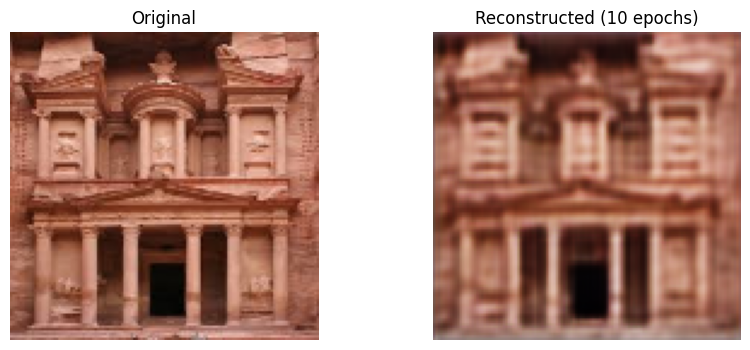

Reconstructing using model trained for 50 epochs
1/1 [==============================] - 0s 23ms/step


Reconstructing using model trained for 150 epochs
1/1 [==============================] - 0s 24ms/step


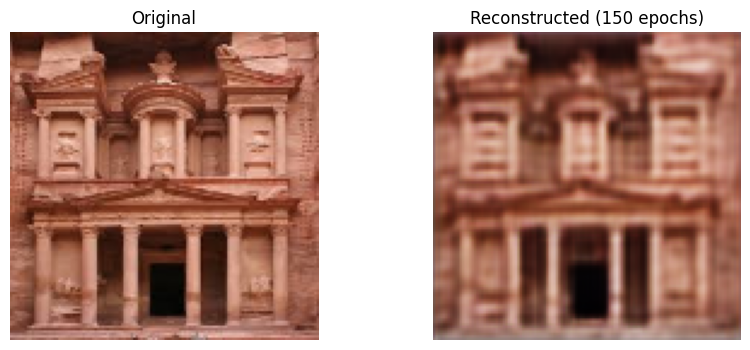

In [25]:
!pip install tensorflow
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float64') / 255.0
    return image

# List of image file paths
image_paths = ['/content/petra1.jpg', '/content/petra2.jpg', '/content/petra3.JPG', '/content/petra4.jpg']

# Load and preprocess images
images = [load_and_preprocess_image(image_path) for image_path in image_paths]

# Separate the images
petra1 = images[0]
training_images = np.array(images[1:])


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

input_shape = training_images.shape[1:]
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()


epochs_list = [10, 50, 150]  # Different epoch values to test
history = {}

for epochs in epochs_list:
    print(f"Training for {epochs} epochs")
    history[epochs] = autoencoder.fit(training_images, training_images,
                                      epochs=epochs,
                                      batch_size=2,
                                      shuffle=True,
                                      validation_data=(training_images, training_images))


# Function to display original and reconstructed images
def display_reconstructed_images(original, reconstructed, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(reconstructed)
    plt.axis('off')
    plt.show()

# Reconstruct and display results for different epochs
for epochs in epochs_list:
    print(f"Reconstructing using model trained for {epochs} epochs")
    reconstructed = autoencoder.predict(np.expand_dims(petra1, axis=0))[0]
    display_reconstructed_images(petra1, reconstructed, f"Reconstructed ({epochs} epochs)")
